In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb


import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler

import gym
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
random_state = 6
np.random.seed(random_state)

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


## Load data

In [4]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_validate.txt"
test_file = "data/rupturemodel_test.txt"

df_train = pd.read_csv(train_file, sep=" ", header=None)
df_val = pd.read_csv(val_file, sep=" ", header=None)
df_test = pd.read_csv(test_file, sep=" ", header=None)

columns = ['height', 'width', 'sxx', 'sxy',
           'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = columns
df_val.columns = columns
df_test.columns = columns

frames = [df_train, df_val]
df_train = pd.concat(frames)
print('train data shape {} and test data shape {}'.format(
    np.shape(df_train), np.shape(df_test)))

train data shape (1600, 9) and test data shape (400, 9)


### Feature Engineering

In [5]:
def create_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    # Create new features
    df_new['height_width_ratio'] = df_new['height'] / df_new['width']
    df_new['normal_stress_diff'] = df_new['sxx'] - df_new['syy']
    df_new['friction_product'] = df_new['mud'] * (df_new['sdrop'])
    df_new['stress_ratio'] = df_new['sxy'] / df_new['syy']
    df_new['static_dynamic_friction_diff'] = (
        df_new['mud'] + df_new['sdrop']) - df_new['mud']
    df_new['stress_diff_dynamic_strength'] = df_new['sxy'] - \
        (df_new['syy'] * df_new['mud'])
    df_new['normalized_dc'] = df_new['dc'] / df_new['width']
    return df_new

In [6]:
# Normalize input data (excluding the 'label' column)
import joblib
train_columns = ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']
scaler = StandardScaler().fit(df_train[train_columns].values)
# Save scaler as pickle file using joblib
joblib.dump(scaler, './models/scaler.joblib')

['./models/scaler.joblib']

In [7]:
# Define your reinforcement learning environment
from typing import List

class GeneratorEnv(gym.Env):
    def __init__(self, supervised_model):
        super(GeneratorEnv, self).__init__()
        self.supervised_model = supervised_model
        self.input_size = 100
        self.scaler = joblib.load('./models/scaler.joblib')
        self.state = torch.randn(100).to(device)
        self.action_space = gym.spaces.Box( low = -5, high = 5, shape = (8,), dtype = np.float32)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(100,), dtype=np.float32)

    def step(self, action):
        self.state = torch.randn(1, self.input_size).to(device)
        reward = self.get_reward(np.array(action))
        done = False
        info = {}
        return self.state.cpu().numpy(), reward, done, info

    def reset(self):
        self.state = torch.randn(100).to(device)
        return self.state.cpu().numpy()

    def get_reward(self, generated_data: np.array) -> np.array:
        columns = ['height', 'width', 'sxx','sxy', 'syy', 'sdrop', 'mud', 'dc']
        de_normalized = self.scaler.inverse_transform(
            generated_data.reshape(1, -1))
        df = pd.DataFrame(de_normalized, columns=columns)
        df = create_new_features(df)
        predict = self.supervised_model.predict(df.values)
        reward = predict
        
        # If predict is out of range, give negative reward
        if predict < 0.0 and predict > 1.0:
            reward =  -1.0
        else:
            reward = 1.0
        
        # Negative reward if the generated height or width is negative
        if (df['width'].values[0] < 0.0) and (df['height'].values[0] < 0.0):
            reward = -1.0
        elif (df['width'].values[0] < 0.0) or (df['height'].values[0] < 0.0):
            reward = -1.0
            
        return reward

In [8]:
# Create the custom environment
model_path = './models/supervised_model_roc_0.8991_f1_0.8266.txt'
supervised_model = lgb.Booster(model_file=model_path)
env = DummyVecEnv([lambda: GeneratorEnv(supervised_model)])

In [9]:
# Train the generator using PPO
model_name = 'rl_model_ppo'
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=dict(pi=[256, 512, 256], vf=[256, 512, 256]))

# Model definition
model = PPO('MlpPolicy', env,
            verbose=0,
            policy_kwargs=policy_kwargs,
            tensorboard_log="./logs/rl_logs/")

In [10]:
# Train the model
model.learn(total_timesteps=500000)

In [11]:
### Save the model
model.save(f'./models/{model_name}')

### Save the environment
joblib.dump(env, f'./models/{model_name}_env.joblib')

['./models/rl_model_ppo_env.joblib']

In [12]:
### Load the model
loaded_model = PPO.load(f'./models/{model_name}')

### Load the environment
loaded_env = joblib.load(f'./models/{model_name}_env.joblib')
loaded_model.set_env(loaded_env)

In [13]:
input_data = torch.randn(5000, 100)
generated_data, _ = loaded_model.predict(input_data)

In [14]:
## Process the generated data to make it compatible with the supervised model
scaler = joblib.load('./models/scaler.joblib')
def process_for_supervised_model(generated_data):
    # Process the generated data to make it compatible with the supervised model
    columns = ['height', 'width', 'sxx',
               'sxy', 'syy', 'sdrop', 'mud', 'dc']
    de_normalized = scaler.inverse_transform(generated_data)  # Reshape to a 2D array
    df = pd.DataFrame(de_normalized, columns=columns)
    df = create_new_features(df)
    return df

data = np.array(generated_data)
df_generated = process_for_supervised_model(data)

In [15]:
columns = ['height', 'width', 'sxx','sxy', 'syy', 'sdrop', 'mud', 'dc']
df_generated[columns].sample(10)

height     width         sxx        sxy         syy     sdrop   
3148  0.199693  1.829953 -142.282761  18.391251  -95.011353  0.413030  \
274   0.088962  1.347829  -79.680557  59.337860 -108.265327  0.362355   
1292  0.171724  1.356801   23.797752  54.462105  -53.389919  0.400305   
4361  0.077295  1.527406 -111.440506  44.077354 -109.224419  0.436789   
2059  0.121627  1.773674  -47.694439  80.307846 -107.047821  0.309660   
1244  0.131599  1.063635  -67.134277  51.109413 -124.098457  0.358017   
1097  0.097301  1.141274  -42.219673  35.675049  -79.288879  0.387323   
4406  0.105289  1.687776  -97.837585  28.915667 -102.099274  0.424945   
1586  0.090334  1.655484  -54.601074  25.800980 -102.426971  0.416531   
2673  0.132062  1.570526 -153.110718  12.207330   -5.549148  0.291055   

           mud        dc  
3148  0.292594  0.308698  
274   0.460895  0.344272  
1292  0.219033  0.338738  
4361  0.279788  0.358814  
2059  0.512061  0.364167  
1244  0.363672  0.376702  
1097  0.171131  0.363368  
4406  0.409840  0.340093  
1586  0.459558  0.413655  
2673  0.267051  0.391599

In [16]:
#Predict the generated data using the supervised model
generated_predict = supervised_model.predict(df_generated.values)
df_generated['label'] = generated_predict

In [17]:
generated_final = df_generated[(df_generated['height'] > 0.0) &
                               (df_generated['width'] > 0.0) &
                               ((df_generated['label'] >= 0.0) & (df_generated['label'] <= 1.0))]


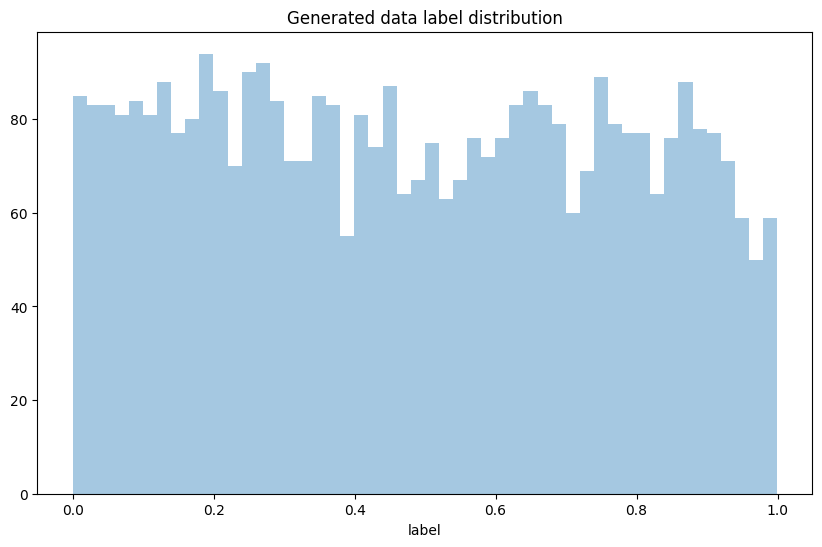

In [29]:
# Plot the generated data label distribution
plt.figure(figsize=(10, 6))
sns.distplot(generated_final['label'], bins=50, kde=False)
plt.title('Generated data label distribution')
plt.show()

In [30]:
# Plot distribution plot using altaire
alt.Chart(generated_final).mark_bar().encode(
    alt.X('label', bin=alt.Bin(maxbins=100)),
    y='count()',
).properties(
    width=600,
    height=400
)

alt.Chart(...)

In [19]:
combined_df = pd.concat([df_train, generated_final], ignore_index=True)
combined_df['data_type'] = ['train'] * \
    len(df_train) + ['generated'] * len(generated_final)


In [20]:
combined_df.to_csv('./data/train_generated_data.csv', index=False)

In [32]:
combined_df.shape

(5429, 17)

In [21]:
combined_df.head()

height     width         sxx        sxy         syy     sdrop       mud   
0  0.103861  1.145663 -102.509086  58.619371 -117.766562  0.483821  0.216681  \
1  0.088714  1.304360 -136.062270  51.391037 -126.715571  0.345944  0.447964   
2  0.099706  1.260377 -117.558936  40.972081 -115.529343  0.292719  0.501697   
3  0.115749  1.191782 -128.169036  94.020712 -157.830504  0.571710  0.202831   
4  0.017900  1.108150 -106.350320  29.148969 -101.379323  0.253122  0.324653   

         dc  label  height_width_ratio  normal_stress_diff  friction_product   
0  0.295842    0.0                 NaN                 NaN               NaN  \
1  0.406466    1.0                 NaN                 NaN               NaN   
2  0.389360    1.0                 NaN                 NaN               NaN   
3  0.408976    0.0                 NaN                 NaN               NaN   
4  0.398592    1.0                 NaN                 NaN               NaN   

   stress_ratio  static_dynamic_friction_diff  stress_diff_dynamic_strength   
0           NaN                           NaN                           NaN  \
1           NaN                           NaN                           NaN   
2           NaN                           NaN                           NaN   
3           NaN                           NaN                           NaN   
4           NaN                           NaN                           NaN   

   normalized_dc data_type  
0            NaN     train  
1            NaN     train  
2            NaN     train  
3            NaN     train  
4            NaN     train

In [31]:
# Plot distribution plot using altaire
alt.Chart(combined_df.sample(4000)).mark_bar().encode(
    alt.X('dc', bin=alt.Bin(maxbins=100)),
    y='count()',
    color='data_type'
).properties(
    width=600,
    height=400
)

alt.Chart(...)